На прошлом семинаре мы рассмотрели, как можно построить простой одношаговый прогноз при помощи глобальной модели машинного обучения. 

Сегодня мы подробнее разберем, а как можно модифицировать такое простое решение? Во-первых, разберем стратегии прогнозирования нескольких временных рядов (не только глобальные — global, но и многомерные — multivariate). Во-вторых, обсудим, какие существуют стратегии построения многошаговых прогнозов (рекурсивная / авторегрессионая — recursive, прямая — direct, множественного выхода — multi-output, etc).

План ноутбука:

0. Быстрое построение бейзлайнов
1. Стратегии прогнозирования нескольких временных рядов и стратегии многошагового прогнозирования

In [1]:
import random
from typing import Sequence, Tuple, Union

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

# Будем использовать CatBoost в качестве базовой модели
import catboost as cb

# Рисование графиков
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Быстрый прогон бейзлайн моделей
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, AutoTheta, Naive, SeasonalNaive

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)


seed_everything()

Будем работать с реальными данными, которые мы уже видели ранее. 

Напомню, что это датасет Tourism, который содержит данные о количестве туристов в разных странах — https://zenodo.org/records/4656096.

Рассмотрим более сложный случай, когда у нас временные ряды являются невыровненными (начинаются и заканчиваются в разное время) и обсудим, какие подводные камни могут возникнуть при этом.

In [3]:
df = pd.read_csv("monash_tourism_monthly.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])

print("Dataset head:")
display(df.head())

print(f"Dataset info:")
display(df.describe())

Dataset head:


id  timestamp     target
0  T000000 1979-01-31  1149.8700
1  T000000 1979-02-28  1053.8002
2  T000000 1979-03-31  1388.8798
3  T000000 1979-04-30  1783.3702
4  T000000 1979-05-31  1921.0252

Dataset info:


timestamp        target
count                         109280  1.092800e+05
mean   1994-07-28 09:39:35.841874048  9.969173e+03
min              1979-01-31 00:00:00  0.000000e+00
25%              1988-01-31 00:00:00  3.080000e+02
50%              1994-11-30 00:00:00  1.287000e+03
75%              2001-02-28 00:00:00  5.761250e+03
max              2007-09-30 00:00:00  1.364825e+06
std                              NaN  3.814709e+04

In [4]:
fig = go.Figure()

seed_everything()
random_ids = np.random.choice(df["id"].unique(), 10, replace=False)

for i in random_ids:
    fig.add_trace(
        go.Scatter(x=df[df["id"] == i]["timestamp"], y=df[df["id"] == i]["target"], name=str(i))
    )

fig.update_layout(
    title="10 случайных рядов из Monash Tourism Dataset",
    xaxis_title="Дата",
    yaxis_title="Значение ряда",
)

fig.show()

Разделим наши данные на train и test по времени: пусть в тест идет последний год наблюдений. Дополнительно выделим валидационную выборку из тренировочной (последние 12 месяцев тренировочной выборки) для использования `early_stopping_rounds` при обучении CatBoost.

In [5]:
HORIZON = 12
HISTORY = 24  # Нужно для ML моделей
MODEL_HORIZON = 1  # Нужно для стратегий прогнозирования


# Добавим признаки из дат прямо в изначальный датасет
df["month"] = df["timestamp"].dt.month
df["quarter"] = df["timestamp"].dt.quarter
df["year"] = df["timestamp"].dt.year

last_year = df["timestamp"].max() - pd.DateOffset(months=HORIZON)

train_val_df = df[df["timestamp"] <= last_year].copy()
train_df = train_val_df[
    train_val_df["timestamp"] <= last_year - pd.DateOffset(months=HORIZON)
].copy()
val_df = train_val_df[train_val_df["timestamp"] > last_year - pd.DateOffset(months=HORIZON)].copy()

test_df = df[df["timestamp"] > last_year].copy()

# Наконец, приведем ряды к одному масштабу
scalers = {}
for unique_id in train_df["id"].unique():
    scaler = StandardScaler()
    train_idx = train_df["id"] == unique_id
    train_values = train_df.loc[train_idx, "target"].values.reshape(-1, 1)
    scaler.fit(train_values)
    scalers[unique_id] = scaler

    # Применяем масштабирование к train, val и test
    for df_ in [train_df, val_df, test_df]:
        idx = df_["id"] == unique_id
        values = df_.loc[idx, "target"].values.reshape(-1, 1)
        if len(values) > 0:
            df_.loc[idx, "target"] = scaler.transform(values).flatten()
            
train_val_df = pd.concat([train_df, val_df])

# По-хорошему, нужно возвращать прогнозы к изначальному масштабу после предсказания модели, но для упрощения мы этого не будем делать

In [6]:
fig = go.Figure()

seed_everything()
random_ids = np.random.choice(df["id"].unique(), 10, replace=False)
colors = px.colors.qualitative.Plotly

for idx, i in enumerate(random_ids):
    color = colors[idx % len(colors)]
    fig.add_trace(
        go.Scatter(
            x=train_df[train_df["id"] == i]["timestamp"],
            y=train_df[train_df["id"] == i]["target"],
            name=f"{i} - train",
            line=dict(color=color),
        )
    )
    fig.add_trace(
        go.Scatter(
            x=val_df[val_df["id"] == i]["timestamp"],
            y=val_df[val_df["id"] == i]["target"],
            name=f"{i} - val",
            line=dict(dash="dot", color=color),
        )
    )
    fig.add_trace(
        go.Scatter(
            x=test_df[test_df["id"] == i]["timestamp"],
            y=test_df[test_df["id"] == i]["target"],
            name=f"{i} - test",
            line=dict(dash="dash", color=color),
        )
    )

fig.update_layout(
    title="Train и Test выборки для 10 случайных рядов из Monash Tourism Dataset",
    xaxis_title="Дата",
    yaxis_title="Значение ряда",
)
fig.show()

В прошлый раз мы этот датасет делили на train и test независимо для каждого временного ряда. Сейчас же мы будем использовать временное разделение для всех рядов сразу. 

## 0. Быстрое построение бейзлайнов

Давайте построим прогнозы для бейзлайн моделей, которые мы рассматривали в прошлом модуле (а заодно вспомним, чем мы вообще занимались). Здесь валидационная выборка не понадобится.

In [7]:
# StatsForecast требует определённого наименования колонок
train_df_for_statsforecast = train_val_df.rename(
    columns={"timestamp": "ds", "id": "unique_id", "target": "y"}
)

# Создаем объект — набор моделей (обучаются независимо друг от друга и независимо на каждый ряд)
sf = StatsForecast(
    models=[
        # AutoARIMA(season_length=12),  # Может считаться очень долго
        AutoETS(season_length=12),
        AutoTheta(season_length=12),
        Naive(),
        SeasonalNaive(season_length=12),
    ],
    freq="ME",
    verbose=True,
)
sf.fit(train_df_for_statsforecast)

# Для прогнозов надо просто подать горизонт прогнозирования
preds = sf.predict(h=HORIZON)

In [8]:
preds

unique_id         ds   AutoETS  AutoTheta     Naive  SeasonalNaive
0      T000000 1994-08-31  2.842548   2.709201  2.775008       2.685428
1      T000000 1994-09-30  1.220162   1.278557  2.775008       1.046095
2      T000000 1994-10-31  0.427481   0.545837  2.775008       0.268523
3      T000000 1994-11-30 -0.240299  -0.012774  2.775008      -0.392324
4      T000000 1994-12-31 -0.025962   0.166472  2.775008      -0.239915
...        ...        ...       ...        ...       ...            ...
4387   T000365 2001-08-31  0.178780   0.242886 -1.566343       0.326793
4388   T000365 2001-09-30  0.014193  -0.240370 -1.566343       0.348267
4389   T000365 2001-10-31 -0.660831  -0.944661 -1.566343      -0.462168
4390   T000365 2001-11-30 -1.221080  -1.417329 -1.566343      -1.092065
4391   T000365 2001-12-31 -1.477617  -1.321000 -1.566343      -1.566343

[4392 rows x 6 columns]

Метрики мы будем считать только на те точки, которые есть в тестовом наборе данных. Если для конкретного временного ряда в тестовом наборе доступны, к примеру, только 6 точек, то и для этого ряда мы будем считать ошибку только по этим 6 точкам. 

In [9]:
def mSMAPE(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-8) -> float:
    numerator = np.abs(y_true - y_pred)
    denominator = np.maximum(np.abs(y_true) + np.abs(y_pred) + eps, 0.5 + eps) / 2
    msmape = 100 * np.mean(numerator / denominator)

    return msmape


def get_metrics(
    test_df: pd.DataFrame,
    forecast_df: pd.DataFrame,
    df_id_column: str = "id",
    df_time_column: str = "timestamp",
    df_target_column: str = "target",
    pred_id_column: str = "unique_id",
    pred_time_column: str = "ds",
) -> dict:
    """Подсчет метрики mSMAPE для всех моделей.
    
    Args:
        test_df: DataFrame с тестовыми данными.
        forecast_df: DataFrame с прогнозами моделей.
        df_id_column: Название колонки с идентификатором ряда в test_df.
        df_time_column: Название колонки с временной меткой в test_df.
        df_target_column: Название колонки с целевой переменной в test_df.
        pred_id_column: Название колонки с идентификатором ряда в forecast_df.
        pred_time_column: Название колонки с временной меткой в forecast_df.

    Returns:
        DataFrame с mSMAPE для всех моделей по всем рядам и по каждому ряду отдельно.

    """
    test_df_with_preds = test_df.merge(
        forecast_df,
        left_on=[df_id_column, df_time_column],
        right_on=[pred_id_column, pred_time_column],
        how="left",
    )

    model_names = [
        col for col in forecast_df.columns if col not in [pred_id_column, pred_time_column]
    ]

    msmape_results = {}

    for model_name in model_names:
        msmape_results[model_name] = {}
        msmape_results[model_name]["all"] = mSMAPE(
            test_df_with_preds[df_target_column].values,
            test_df_with_preds[model_name].values,
        )
        for series_id in test_df[df_id_column].unique():
            test_series = test_df_with_preds[test_df_with_preds[df_id_column] == series_id]
            msmape_series = mSMAPE(
                test_series[df_target_column].values,
                test_series[model_name].values,
            )
            msmape_results[model_name][series_id] = msmape_series

    df_msmape = pd.DataFrame(msmape_results)

    return df_msmape


def plot_results(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    forecast_df: pd.DataFrame,
    df_id_column: str = "id",
    df_time_column: str = "timestamp",
    df_target_column: str = "target",
    pred_id_column: str = "unique_id",
    pred_time_column: str = "ds",
    num_samples_to_plot: int = 5,
    seed: int = 42,
):
    """Функция для визуализации результатов прогнозирования. 
        Разные модели отображаются разными линиями. 
        Разные ряды — в разных графиках.
    
    Args:
        train_df: DataFrame с тренировочными данными.
        test_df: DataFrame с тестовыми данными.
        forecast_df: DataFrame с прогнозами моделей.
        df_id_column: Название колонки с идентификатором ряда в train_df и test_df.
        df_time_column: Название колонки с временной меткой в train_df и test_df.
        df_target_column: Название колонки с целевой переменной в train_df и test_df.
        pred_id_column: Название колонки с идентификатором ряда в forecast_df.
        pred_time_column: Название колонки с временной меткой в forecast_df.
        num_samples_to_plot: Количество рядов для визуализации.
        seed: Сид для рандома при выборе рядов.
        
    """
    test_df_with_preds = test_df.merge(
        forecast_df,
        left_on=[df_id_column, df_time_column],
        right_on=[pred_id_column, pred_time_column],
        how="left",
    )

    model_names = [
        col for col in forecast_df.columns if col not in [pred_id_column, pred_time_column]
    ]

    random.seed(seed)
    unique_ids = test_df[df_id_column].unique()
    sampled_ids = random.sample(list(unique_ids), num_samples_to_plot)

    for series_id in sampled_ids:
        fig = go.Figure()

        train_series = train_df[train_df[df_id_column] == series_id]
        test_series = test_df_with_preds[test_df_with_preds[df_id_column] == series_id]
        forecast_series = forecast_df[forecast_df[pred_id_column] == series_id]

        for name in model_names:
            fig.add_trace(
                go.Scatter(
                    x=forecast_series[pred_time_column],
                    y=forecast_series[name],
                    mode="lines",
                    line=dict(dash="dash"),
                    name=f"Forecast {name} {series_id}",
                )
            )
        fig.add_trace(
            go.Scatter(
                x=train_series[df_time_column],
                y=train_series[df_target_column],
                mode="lines",
                name=f"Train {series_id}",
            )
        )
        fig.add_trace(
            go.Scatter(
                x=test_series[df_time_column],
                y=test_series[df_target_column],
                mode="lines",
                name=f"Test {series_id}",
            )
        )
        fig.update_layout(
            xaxis_title="Дата",
            yaxis_title="Значение ряда",
            title=f"Результаты прогнозирования для ряда {series_id}",
        )
        fig.show()

In [10]:
all_metrics = get_metrics(test_df, preds)
print("Метрики бейзлайнов:")
display(all_metrics)

Метрики бейзлайнов:


AutoETS  AutoTheta       Naive  SeasonalNaive
all      41.734864  51.381169   83.896827      46.723565
T000002   4.777039  10.421751   56.836260       6.307835
T000003  31.967272  36.523979  116.222798      16.186446
T000004   8.660729   9.818242   11.895705      14.980118
T000005  38.439456  40.741548   83.591740      40.501842
...            ...        ...         ...            ...
T000349   8.739787  33.412279   71.758210      13.069563
T000350   6.736044  23.884111   46.895585      10.945495
T000351   6.967444  12.371776   21.949806       8.645614
T000352  18.860683  20.391142   26.748083      18.486980
T000353   4.796933  20.092940   47.675704       9.226642

[353 rows x 4 columns]

In [11]:
random.seed(42)
unique_ids = test_df["id"].unique()
sampled_ids = random.sample(list(unique_ids), 3)

print("Метрики для рядов из подвыборки:")
display(all_metrics.loc[sampled_ids])

Метрики для рядов из подвыборки:


AutoETS  AutoTheta       Naive  SeasonalNaive
T000329  47.368977  45.530686  174.038913      87.283682
T000059  35.327768  59.533393   64.817416      30.595598
T000014   8.714012   9.515189   19.774373      17.341939

In [12]:
plot_results(
    train_df=train_val_df,
    test_df=test_df,
    forecast_df=preds,
    df_id_column="id",
    df_time_column="timestamp",
    df_target_column="target",
    pred_id_column="unique_id",
    pred_time_column="ds",
    num_samples_to_plot=3,
    seed=42,
)

## 1. Стратегии прогнозирования нескольких временных рядов и стратегии многошагового прогнозирования

Сначала немного теории.

Сначала поговорим про ситуацию, когда у нас есть несколько временных рядов, и мы хотим построить прогнозы для всех из них.

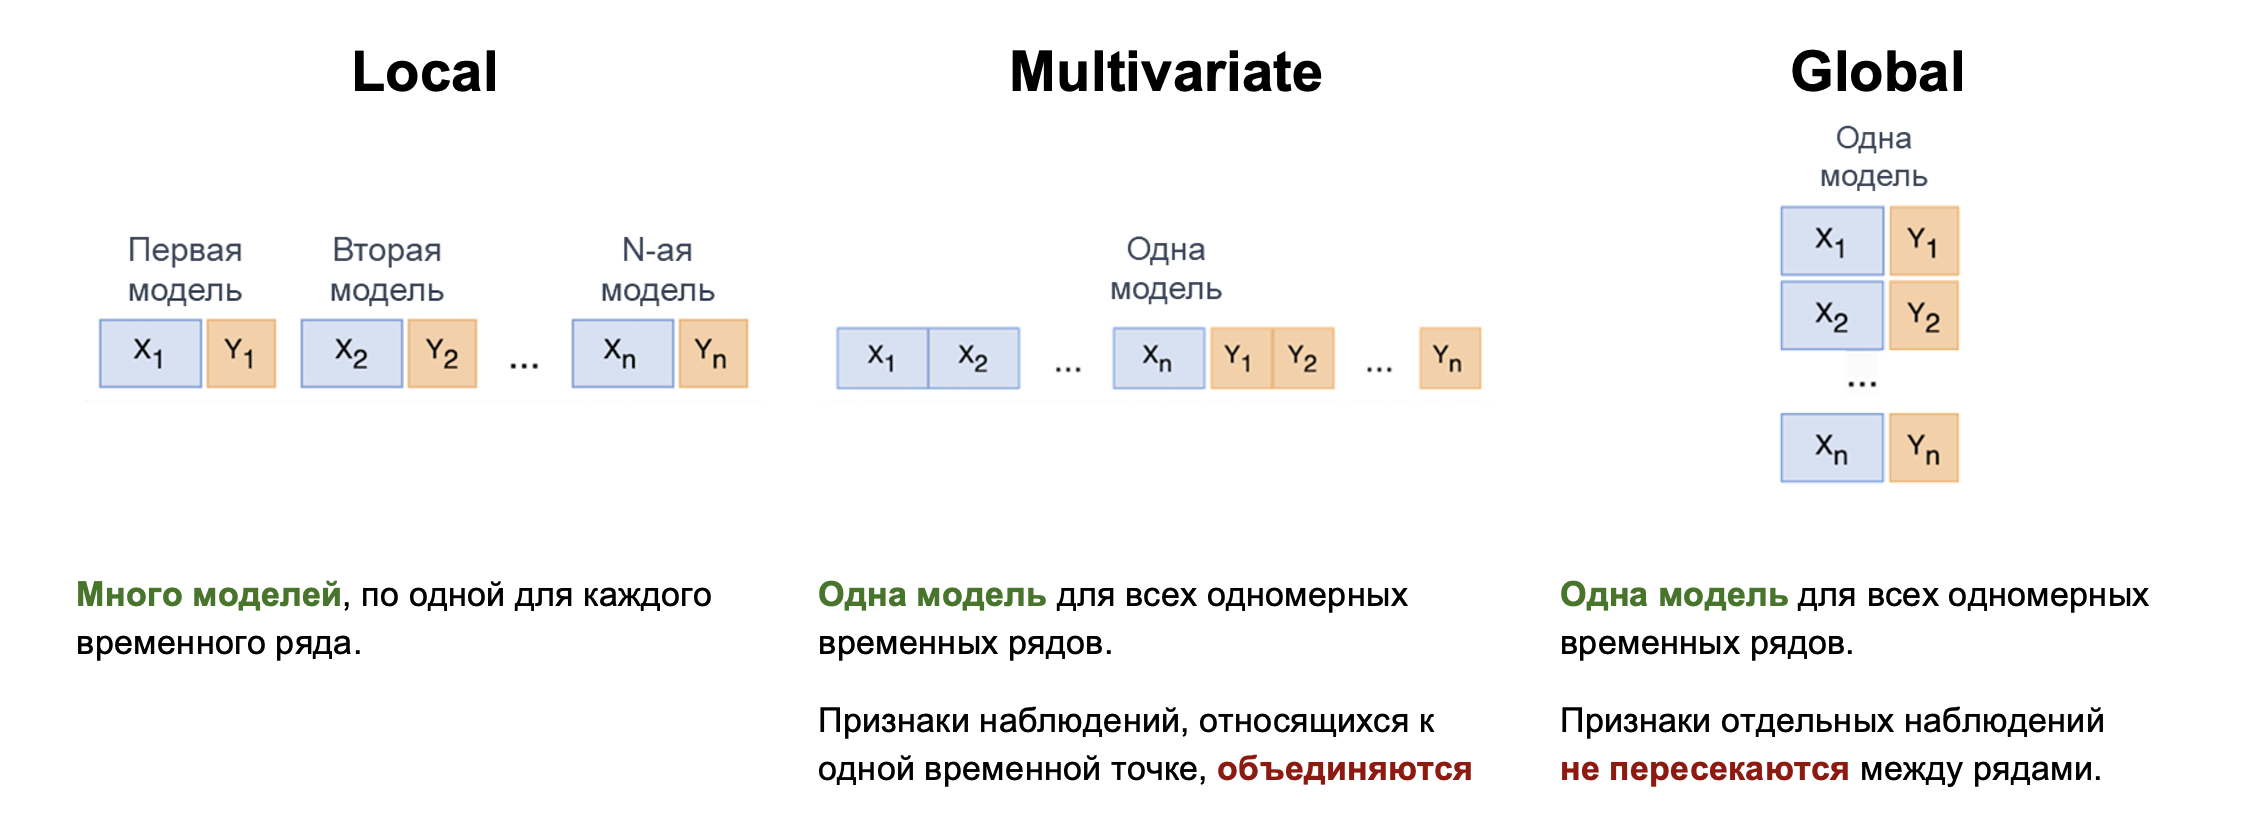

Можно использовать и некоторые промежуточные подходы — например, использовать кластеризацию временных рядов и поверх кластеров уже обучать и запускать глобальные / многомерные модели. 

---

На прошлом семинаре мы рассматривали одношаговый прогноз. Но в жизни гораздо чаще вы столкнетесь с задачей многошагового прогнозирования. Например, вам нужно спрогнозировать продажи на неделю вперед, а не только на следующий день.

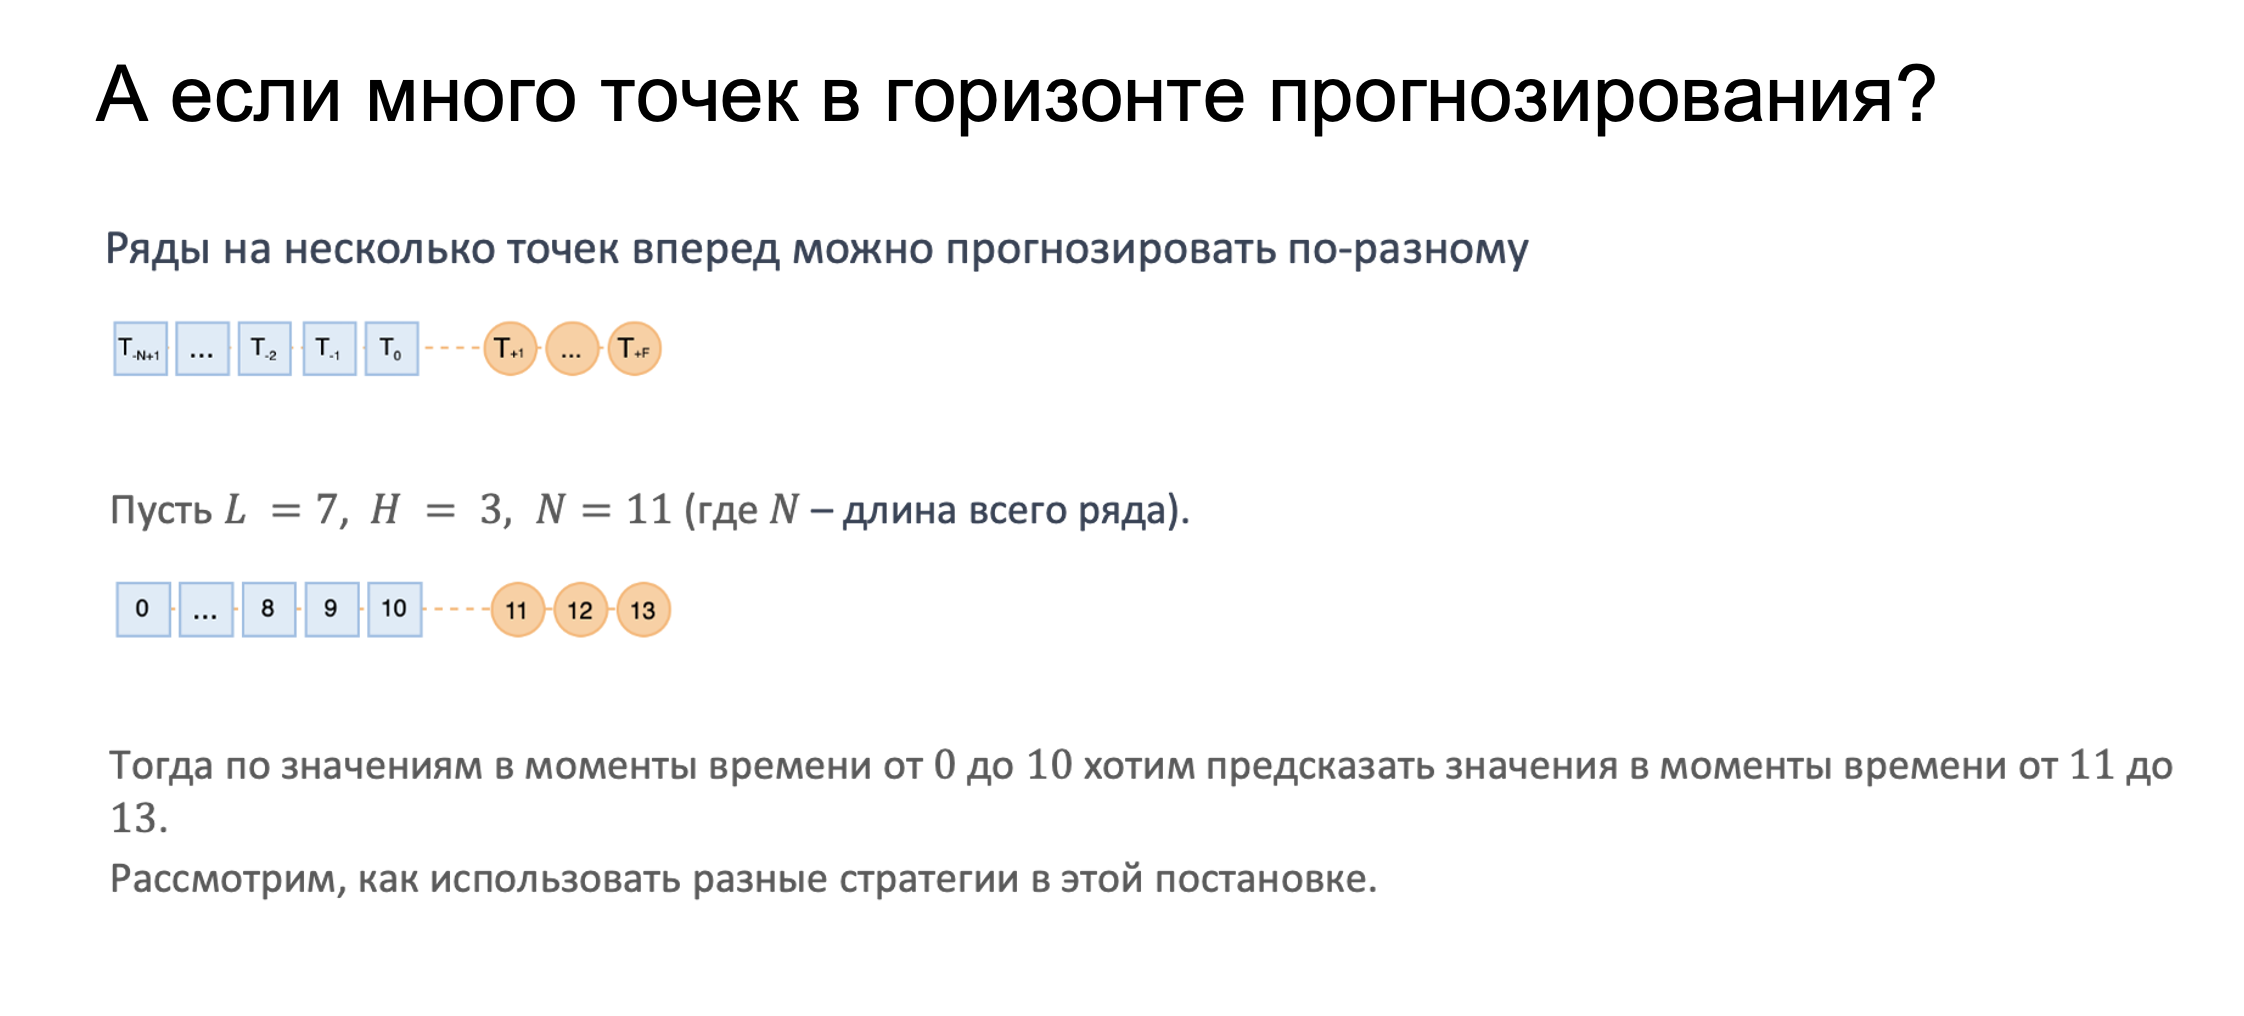

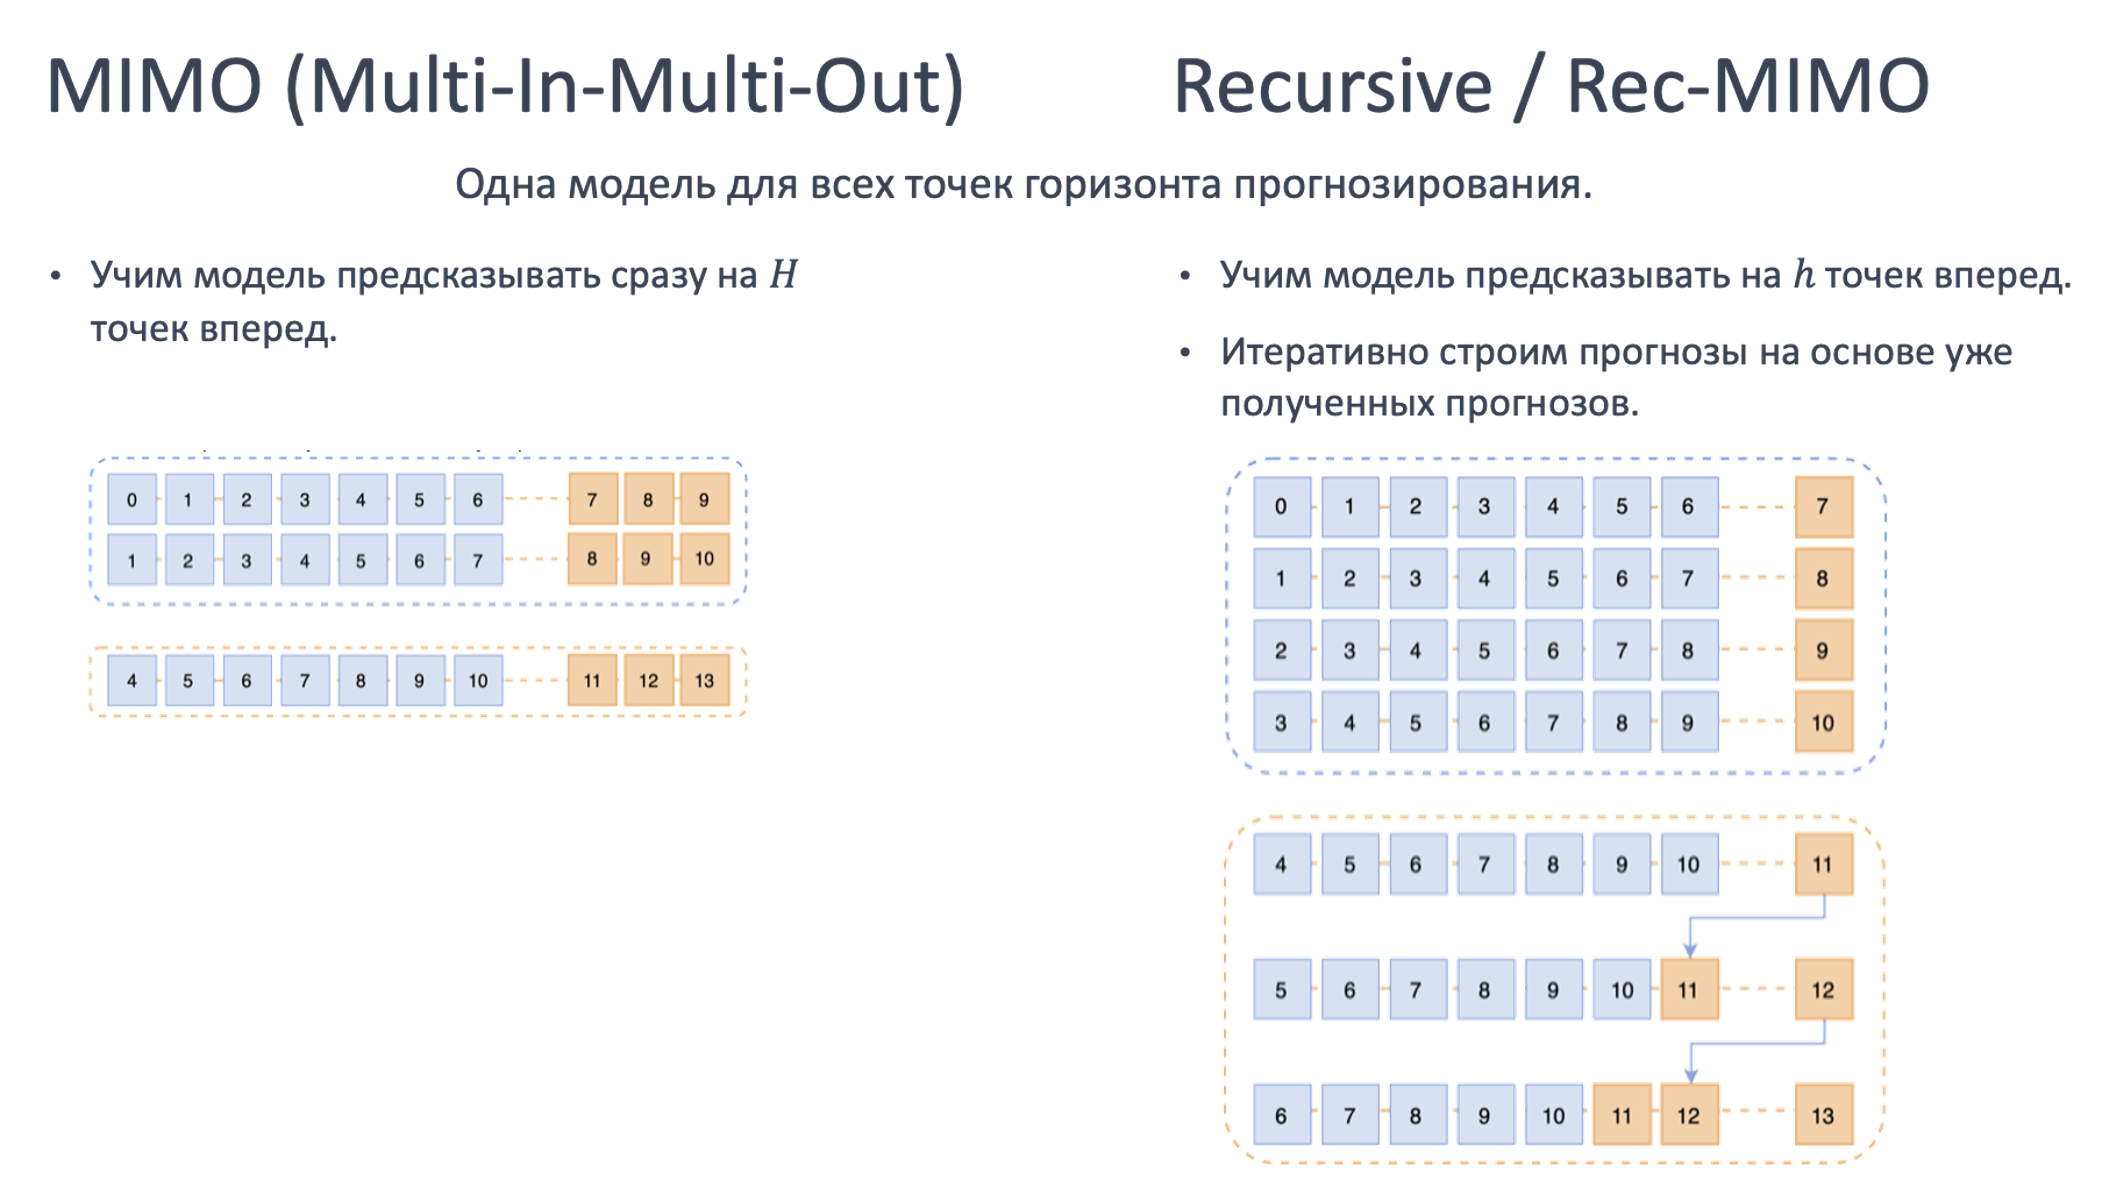

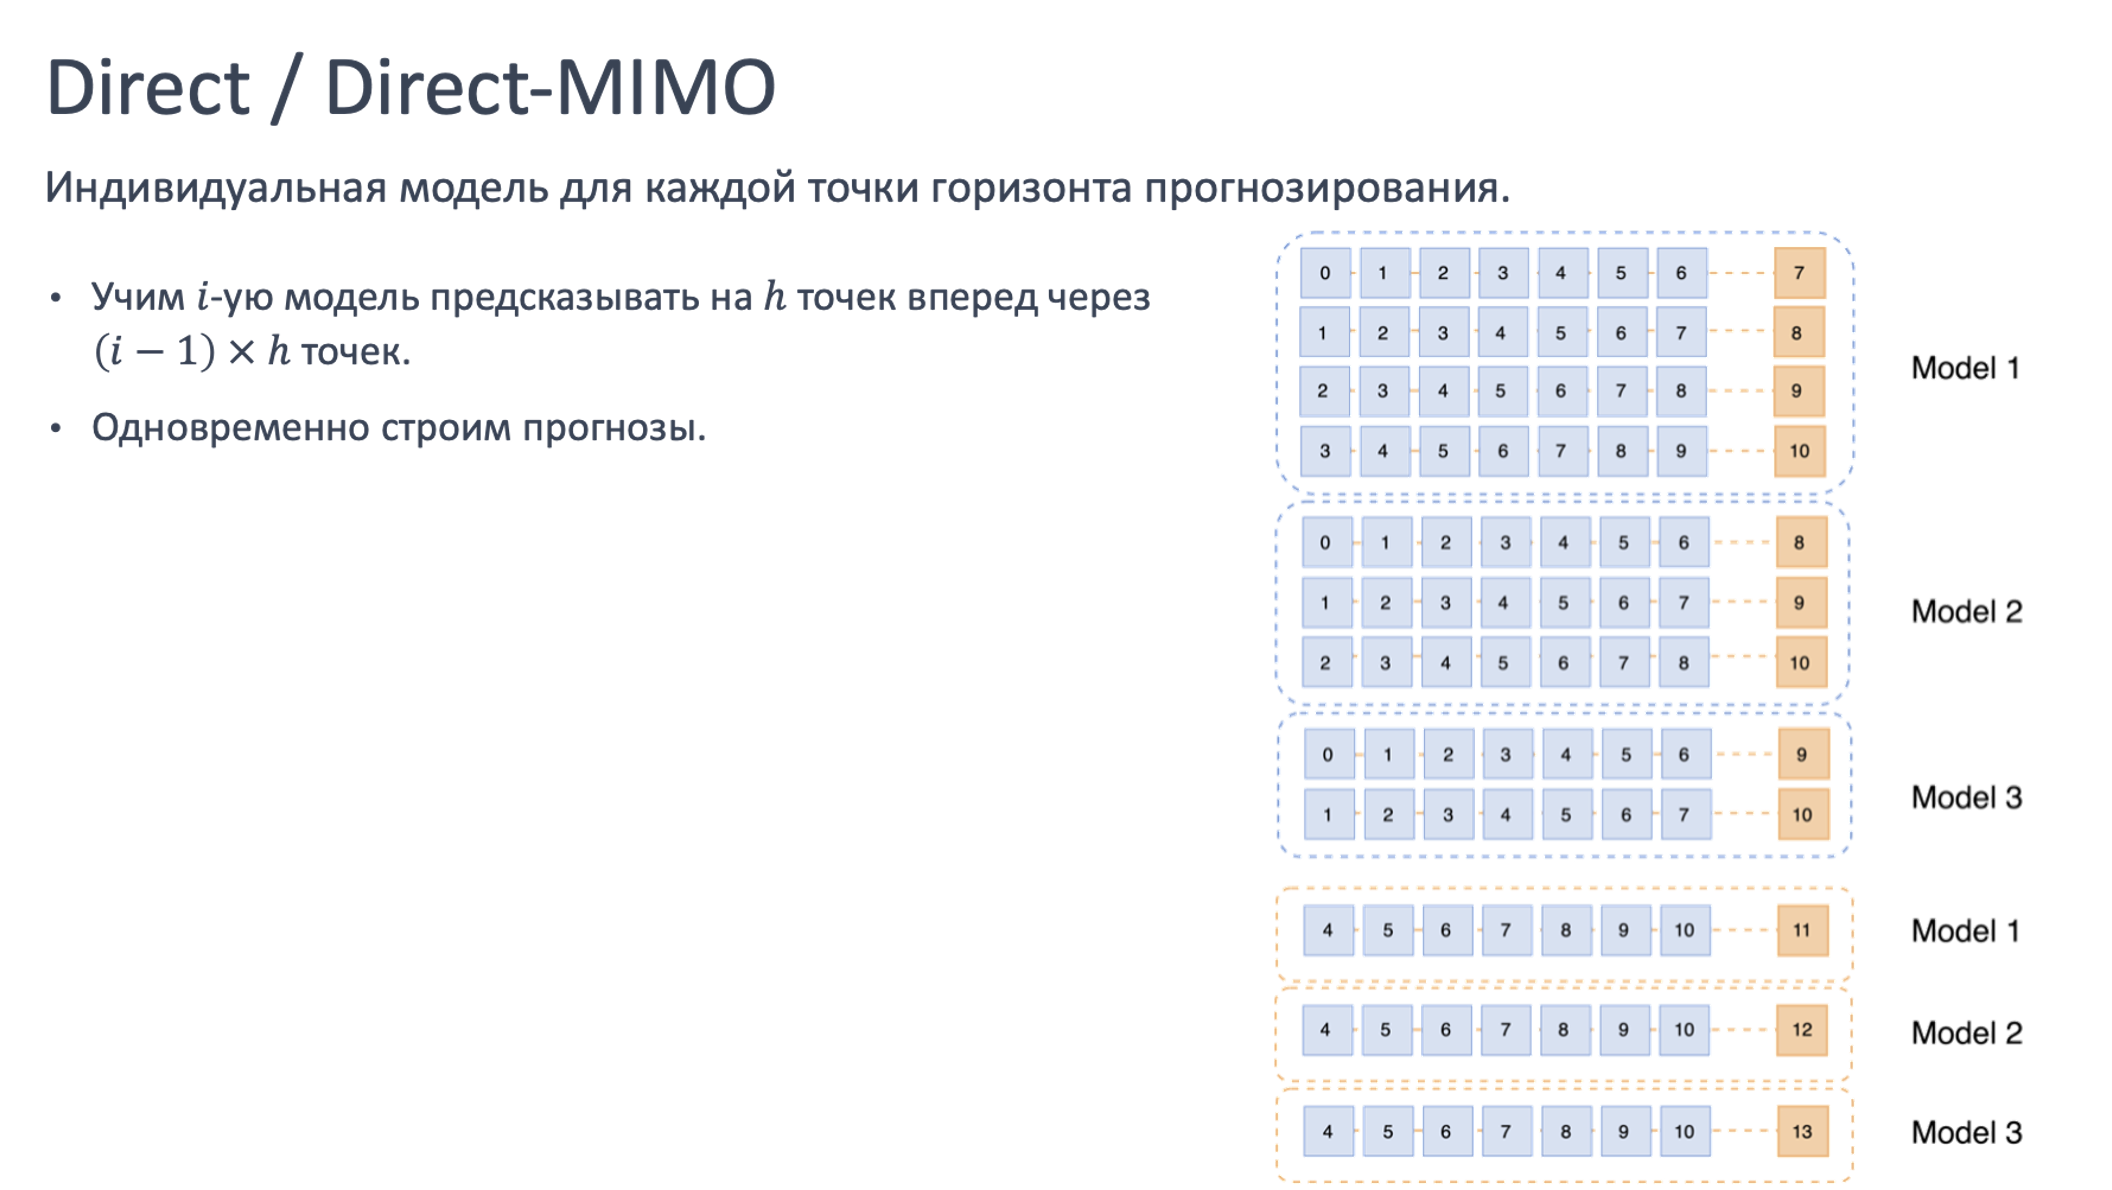

---

Теперь предлагаем своими руками собрать несколько вариантов простых решений, сочетающих в себе разные стратегии.

Будем пользовать не функционалом pandas (shift, rolling и т.д.), а массивами индексов и срезами. Это позволит лучше понять, как работают эти стратегии, и избежать неприятных ситуаций с ликами.

### Global + Recursive-MIMO

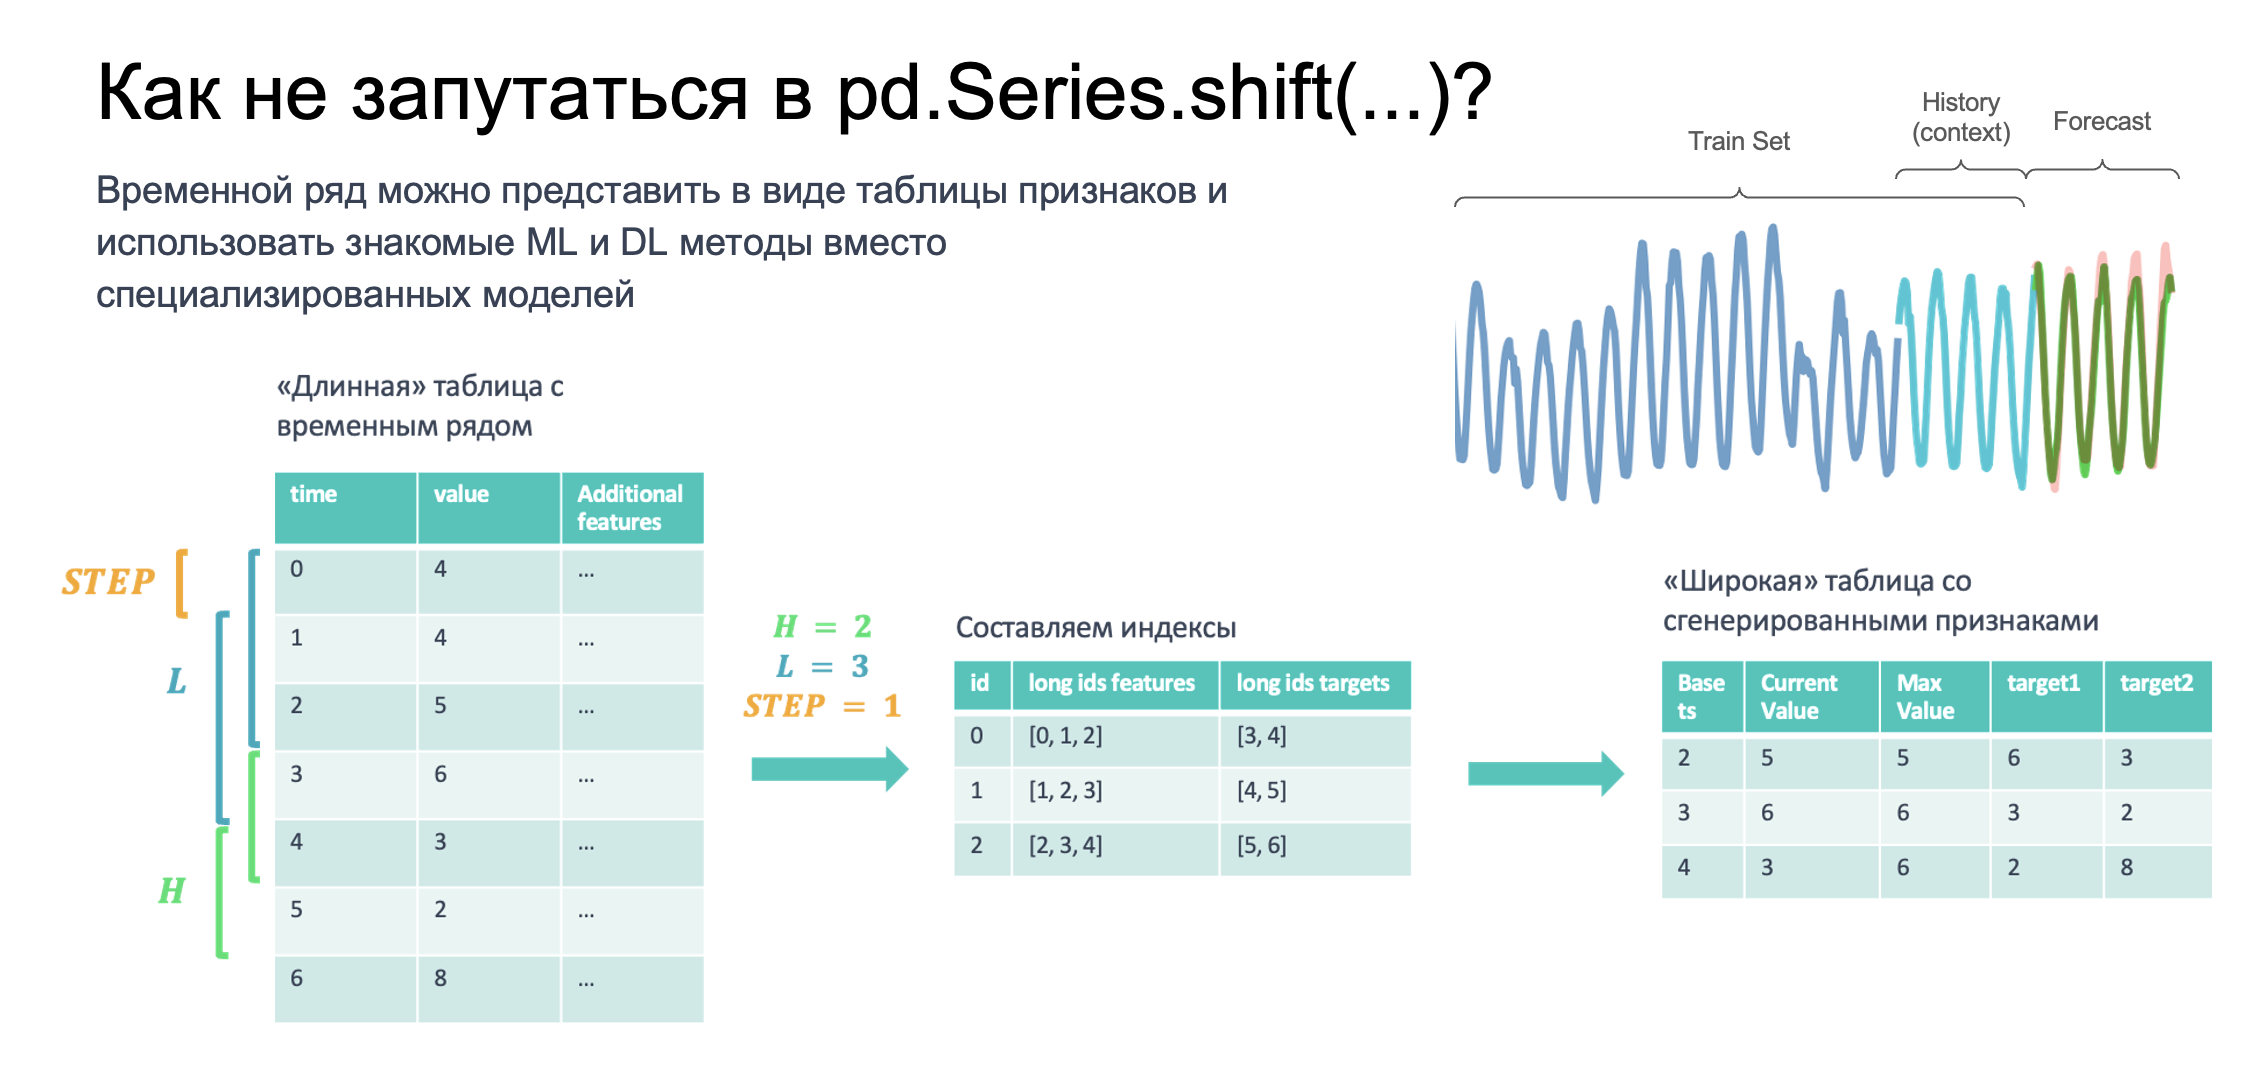

### Обучение модели

В рекурсивной стратегии сначала учим модель предсказывать на `h_model` точек вперед. 

In [13]:
def features_targets__train_idx(
    id_column: pd.Series,
    series_length: int,
    model_horizon: int,
    history_size: int,
) -> np.ndarray:
    """Создание индексов для формирования обучающей выборки (признаков и таргетов) для многомерных временных рядов.
    Args:
        id_column: Колонка с идентификаторами рядов.
        series_length: Общая длина всех рядов.
        model_horizon: Горизонт прогнозирования модели.
        history_size: Размер окна истории.

    Returns:
        Индексы для формирования признаков и таргетов.

    """
    series_start_indices = np.append(
        np.unique(id_column.values, return_index=True)[1], series_length
    )

    features_indices = []
    targets_indices = []
    for i in range(len(series_start_indices) - 1):
        series_start = series_start_indices[i]
        series_end = series_start_indices[i + 1]

        if series_end - series_start < history_size + model_horizon:
            continue  # Пропускаем ряды, которые слишком короткие для формирования окна истории + таргета

        sliding_window = np.lib.stride_tricks.sliding_window_view(
            np.arange(series_start, series_end),
            history_size + model_horizon,
        )

        features_indices.append(sliding_window[:, :history_size])
        targets_indices.append(sliding_window[:, history_size:])

    features_indices = np.vstack(features_indices)
    targets_indices = np.vstack(targets_indices)

    return features_indices, targets_indices


def features__test_idx(
    id_column: pd.Series,
    series_length: int,
    model_horizon: int,
    history_size: int,
) -> np.ndarray:
    """Создание индексов для формирования тестовой выборки для многомерных временных рядов.
    Args:
        id_column: Колонка с идентификаторами рядов.
        series_length: Общая длина всех рядов.
        model_horizon: Горизонт прогнозирования модели.
        history_size: Размер окна истории.

    Returns:
        Индексы для формирования признаков.
        Обратите внимание, что для признаков тестовой выборки нужны только последние history индексов.

    """
    series_start_indices = np.append(
        np.unique(id_column.values, return_index=True)[1], series_length
    )

    features_indices = []
    targets_indices = []
    for i in range(len(series_start_indices) - 1):
        series_start = series_start_indices[i]
        series_end = series_start + history_size + model_horizon

        if series_end - series_start < history_size + model_horizon:
            AssertionError(f"Ряд {i} слишком короткий для формирования окна истории + таргета")

        sliding_window = np.lib.stride_tricks.sliding_window_view(
            np.arange(series_start, series_end),
            history_size + model_horizon,
        )

        features_indices.append(sliding_window[:, :history_size])
        targets_indices.append(sliding_window[:, history_size:])

    features_indices = np.vstack(features_indices)
    targets_indices = np.vstack(targets_indices)

    return features_indices, targets_indices

In [14]:
train_features_idx, train_targets_idx = features_targets__train_idx(
    id_column=train_df["id"],
    series_length=len(train_df),
    model_horizon=MODEL_HORIZON,
    history_size=HISTORY,
)

# К валидационной выборке нужно присоединить историю из обучающей выборки
train_history_df = train_df[
    train_df["timestamp"] >= val_df["timestamp"].min() - pd.DateOffset(months=HISTORY)
]
history_val_df = pd.concat([train_history_df, val_df], ignore_index=True)
history_val_df = history_val_df.sort_values(by=["id", "timestamp"])

val_features_idx, val_targets_idx = features_targets__train_idx(
    id_column=history_val_df["id"],
    series_length=len(history_val_df),
    model_horizon=MODEL_HORIZON,
    history_size=HISTORY,
)

print(f"Длина обучающей выборки: {len(train_df)}")
print("Индексы признаков для обучающей выборки:")
display(train_features_idx)
print("Индексы таргетов для обучающей выборки:")
display(train_targets_idx)

print(f"Длина валидационной выборки: {len(history_val_df)}")
print("Индексы признаков для валидационной выборки:")
display(val_features_idx)
print("Индексы таргетов для валидационной выборки:")
display(val_targets_idx)

Длина обучающей выборки: 101402
Индексы признаков для обучающей выборки:


array([[     0,      1,      2, ...,     21,     22,     23],
       [     1,      2,      3, ...,     22,     23,     24],
       [     2,      3,      4, ...,     23,     24,     25],
       ...,
       [101375, 101376, 101377, ..., 101396, 101397, 101398],
       [101376, 101377, 101378, ..., 101397, 101398, 101399],
       [101377, 101378, 101379, ..., 101398, 101399, 101400]])

Индексы таргетов для обучающей выборки:


array([[    24],
       [    25],
       [    26],
       ...,
       [101399],
       [101400],
       [101401]])

Длина валидационной выборки: 12672
Индексы признаков для валидационной выборки:


array([[    0,     1,     2, ...,    21,    22,    23],
       [    1,     2,     3, ...,    22,    23,    24],
       [    2,     3,     4, ...,    23,    24,    25],
       ...,
       [12645, 12646, 12647, ..., 12666, 12667, 12668],
       [12646, 12647, 12648, ..., 12667, 12668, 12669],
       [12647, 12648, 12649, ..., 12668, 12669, 12670]])

Индексы таргетов для валидационной выборки:


array([[   24],
       [   25],
       [   26],
       ...,
       [12669],
       [12670],
       [12671]])

Обратите внимание, что мы должны аккуратно обработать стыки между рядами с разными id.

In [15]:
print(f"Длина первого ряда: {len(train_df[train_df['id'] == train_df['id'].unique()[0]])}")
print("Индексы признаков на стыке между первым и вторым рядом:")
display(train_features_idx[160:170])
print("Индексы таргетов на стыке между первым и вторым рядом:")
display(train_targets_idx[160:170])

Длина первого ряда: 187
Индексы признаков на стыке между первым и вторым рядом:


array([[160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183],
       [161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184],
       [162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
        175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185],
       [187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
        200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210],
       [188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
        201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211],
       [189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
        202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212],
       [190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
        203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213],
       [191, 192, 193, 194, 195, 196, 197

Индексы таргетов на стыке между первым и вторым рядом:


array([[184],
       [185],
       [186],
       [211],
       [212],
       [213],
       [214],
       [215],
       [216],
       [217]])

Индексы ограничивают для нас те точки из "длинного" ряда, которые мы можем использовать для формирования обучающих примеров для соответствующих таргетов. Теперь на основе этих индексов нам нужно сформировать обучающие примеры.

Для простоты будем использовать только лаговые признаки и признаки из дат.

In [16]:
def get_slice(data: pd.DataFrame, k: Tuple[np.ndarray]) -> np.ndarray:
    """Получение среза из DataFrame по индексам строк и колонок.
    
    Args:
        data: Исходный DataFrame.
        k: Кортеж из двух элементов:
            - Массив индексов строк.
            - Массив индексов колонок или None (если нужны все колонки).
            
    Returns:
        Массив значений из DataFrame по заданным индексам.

    """    
    rows, cols = k
    if cols is None:
        new_data = data.values[rows]
    else:
        new_data = data.iloc[:, cols].values[rows]

    if new_data.ndim == 3:
        new_data = new_data.reshape(new_data.shape[0], -1)

    return new_data

In [17]:
print("Например для таргета под индексом 175 мы можем использовать следующие признаки:")
print(get_slice(train_df, (train_features_idx[175], None)))

print("\n А сам таргет при этом:")
print(get_slice(train_df, (train_targets_idx[175], None)))

Например для таргета под индексом 175 мы можем использовать следующие признаки:
[['T000001' Timestamp('1980-01-31 00:00:00') -1.361134604248234 1 1 1980]
 ['T000001' Timestamp('1980-02-29 00:00:00') -1.6298383187898011 2 1 1980]
 ['T000001' Timestamp('1980-03-31 00:00:00') -1.5859063163492157 3 1 1980]
 ['T000001' Timestamp('1980-04-30 00:00:00') -1.2297765811631818 4 2 1980]
 ['T000001' Timestamp('1980-05-31 00:00:00') -1.052951170427701 5 2 1980]
 ['T000001' Timestamp('1980-06-30 00:00:00') -1.00586234201359 6 2 1980]
 ['T000001' Timestamp('1980-07-31 00:00:00') -0.06920338192117702 7 3
  1980]
 ['T000001' Timestamp('1980-08-31 00:00:00') 0.25304769457070286 8 3 1980]
 ['T000001' Timestamp('1980-09-30 00:00:00') -0.28692701572159557 9 3
  1980]
 ['T000001' Timestamp('1980-10-31 00:00:00') -0.6595254719722179 10 4
  1980]
 ['T000001' Timestamp('1980-11-30 00:00:00') -1.2279293409015153 11 4
  1980]
 ['T000001' Timestamp('1980-12-31 00:00:00') -1.4534986723895744 12 4
  1980]
 ['T00000

In [18]:
def get_cols_idx(data: pd.DataFrame, columns: Union[str, Sequence[str]]) -> Union[int, np.ndarray]:
    """Получение индексов колонок по их названиям.

    Args:
        data: DataFrame с колонками.
        columns: Название колонки или список названий колонок.

    Returns:
        Индекс колонки или массив индексов колонок.

    """
    if type(columns) is str:
        idx = data.columns.get_loc(columns)
    else:
        idx = data.columns.get_indexer(columns)
    return idx

In [19]:
def get_features_df_and_targets(
    df: pd.DataFrame,
    features_ids,
    targets_ids,
    id_column: Union[str, Sequence[str]] = "id",
    date_column: Union[str, Sequence[str]] = ["month", "quarter", "year"],
    target_column: str = "target",
):
    # Признаки идентификатора ряда и времени возьмем из таргетных индексов
    features_df_id = get_slice(df, (targets_ids, get_cols_idx(df, id_column)))
    features_time = get_slice(
        df, (targets_ids, get_cols_idx(df, date_column))
    )

    # Лаговые признаки возьмем из индексов признаков. Все доступные из истории
    features_lags = get_slice(
        df,
        (features_ids, get_cols_idx(df, target_column)),
    )

    # Объединим все признаки в один массив
    features = np.hstack([features_df_id, features_time, features_lags])
    categorical_features_idx = np.arange(
        features_df_id.shape[1] + features_time.shape[1]
    )  # Отметим категориальные признаки для CatBoost

    # Сформируем таргеты
    targets = get_slice(df, (targets_ids, get_cols_idx(df, target_column)))
    return features, targets, categorical_features_idx

In [20]:
train_features, train_targets, categorical_features_idx = get_features_df_and_targets(
    train_df,
    train_features_idx,
    train_targets_idx,
)

val_features, val_targets, _ = get_features_df_and_targets(
    history_val_df,
    val_features_idx,
    val_targets_idx,
)

In [21]:
print("Признаки для обучающей выборки:")
display(train_features)
print("Из них категориальные признаки имеют индексы:")
print(categorical_features_idx)
print("\n Таргеты для обучающей выборки:")
display(train_targets)

Признаки для обучающей выборки:


array([['T000000', 1, 1, ..., -0.8216024273429237, -1.118899608065676,
        -1.066437641836856],
       ['T000000', 2, 1, ..., -1.118899608065676, -1.066437641836856,
        -1.1633533703274002],
       ['T000000', 3, 1, ..., -1.066437641836856, -1.1633533703274002,
        -1.2054672891342972],
       ...,
       ['T000365', 10, 4, ..., 0.5452421977630448, 0.32679316680168574,
        0.3482669186316252],
       ['T000365', 11, 4, ..., 0.32679316680168574, 0.3482669186316252,
        -0.46216838191312587],
       ['T000365', 12, 4, ..., 0.3482669186316252, -0.46216838191312587,
        -1.0920651022580157]], dtype=object)

Из них категориальные признаки имеют индексы:
[0 1 2 3]

 Таргеты для обучающей выборки:


array([[-1.16335337],
       [-1.20546729],
       [-1.06037409],
       ...,
       [-0.46216838],
       [-1.0920651 ],
       [-1.5663434 ]])

In [22]:
train_features

array([['T000000', 1, 1, ..., -0.8216024273429237, -1.118899608065676,
        -1.066437641836856],
       ['T000000', 2, 1, ..., -1.118899608065676, -1.066437641836856,
        -1.1633533703274002],
       ['T000000', 3, 1, ..., -1.066437641836856, -1.1633533703274002,
        -1.2054672891342972],
       ...,
       ['T000365', 10, 4, ..., 0.5452421977630448, 0.32679316680168574,
        0.3482669186316252],
       ['T000365', 11, 4, ..., 0.32679316680168574, 0.3482669186316252,
        -0.46216838191312587],
       ['T000365', 12, 4, ..., 0.3482669186316252, -0.46216838191312587,
        -1.0920651022580157]], dtype=object)

In [23]:
cb_model = cb.CatBoostRegressor(
    loss_function="MultiRMSE",
    random_seed=42,
    verbose=100,
    early_stopping_rounds=100,
    iterations=1500,
    cat_features=categorical_features_idx,
)

train_dataset = cb.Pool(
    data=train_features, label=train_targets, cat_features=categorical_features_idx
)
eval_dataset = cb.Pool(data=val_features, label=val_targets, cat_features=categorical_features_idx)

cb_model.fit(
    train_dataset,
    eval_set=eval_dataset,
    use_best_model=True,
    plot=False,
)

0:	learn: 0.9781824	test: 1.7666657	best: 1.7666657 (0)	total: 76.6ms	remaining: 1m 54s
100:	learn: 0.4806739	test: 0.7670441	best: 0.7670441 (100)	total: 1.77s	remaining: 24.5s
200:	learn: 0.4557572	test: 0.7110435	best: 0.7110435 (200)	total: 3.76s	remaining: 24.3s
300:	learn: 0.4450125	test: 0.6970050	best: 0.6970050 (300)	total: 5.46s	remaining: 21.7s
400:	learn: 0.4382850	test: 0.6911411	best: 0.6911127 (398)	total: 7.15s	remaining: 19.6s
500:	learn: 0.4333077	test: 0.6880751	best: 0.6876625 (499)	total: 8.76s	remaining: 17.5s
600:	learn: 0.4285925	test: 0.6840512	best: 0.6840325 (599)	total: 10.6s	remaining: 15.8s
700:	learn: 0.4247584	test: 0.6790080	best: 0.6786738 (690)	total: 13.1s	remaining: 14.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6786737967
bestIteration = 690

Shrink model to first 691 iterations.


Вот мы и обучили модель предсказывать на `h_model` точек вперед. Теперь мы можем использовать эту модель рекурсивно, чтобы предсказывать на `h` точек вперед.

### Формирование прогноза

Как понятно из названия, формирование прогноза происходит рекурсивно.

In [24]:
# Для формирования тестовой выборки нужно продолжить историю из обучающей-валидационной выборки на горизонт прогнозирования
test_df_to_predict = train_val_df[
    train_val_df["timestamp"] >= test_df["timestamp"].min() - pd.DateOffset(months=HISTORY)
]

new_segments = []
for current_id in test_df_to_predict["id"].unique():
    segment_df = test_df_to_predict[test_df_to_predict["id"] == current_id].copy()
    last_timestamp = segment_df["timestamp"].max()

    new_timestamps = pd.date_range(
        start=last_timestamp + pd.DateOffset(months=1),
        periods=HORIZON,
        freq="ME",
    )
    
    new_segment = pd.DataFrame(
        {
            "id": current_id,
            "timestamp": new_timestamps,
            "target": np.nan,
            "month": new_timestamps.month,
            "quarter": new_timestamps.quarter,
            "year": new_timestamps.year,
        }
    )
    new_segment = pd.concat([segment_df, new_segment], ignore_index=True)
    new_segments.append(new_segment)

test_df_to_predict = pd.concat(new_segments, ignore_index=True)

In [25]:
test_df_to_predict[:29]

id  timestamp    target  month  quarter  year
0   T000002 2004-10-31  2.911217     10        4  2004
1   T000002 2004-11-30  2.183566     11        4  2004
2   T000002 2004-12-31  1.342060     12        4  2004
3   T000002 2005-01-31  1.373056      1        1  2005
4   T000002 2005-02-28  0.012258      2        1  2005
5   T000002 2005-03-31  2.325505      3        1  2005
6   T000002 2005-04-30  2.167128      4        2  2005
7   T000002 2005-05-31  1.518756      5        2  2005
8   T000002 2005-06-30  2.017242      6        2  2005
9   T000002 2005-07-31  2.050786      7        3  2005
10  T000002 2005-08-31  1.269513      8        3  2005
11  T000002 2005-09-30  1.249557      9        3  2005
12  T000002 2005-10-31  2.842189     10        4  2005
13  T000002 2005-11-30  2.596949     11        4  2005
14  T000002 2005-12-31  1.490550     12        4  2005
15  T000002 2006-01-31  1.101491      1        1  2006
16  T000002 2006-02-28  0.379299      2        1  2006
17  T000002 2006-03-31  2.427653      3        1  2006
18  T000002 2006-04-30  2.337212      4        2  2006
19  T000002 2006-05-31  1.587845      5        2  2006
20  T000002 2006-06-30  2.181140      6        2  2006
21  T000002 2006-07-31  2.136799      7        3  2006
22  T000002 2006-08-31  1.234150      8        3  2006
23  T000002 2006-09-30  1.288924      9        3  2006
24  T000002 2006-10-31       NaN     10        4  2006
25  T000002 2006-11-30       NaN     11        4  2006
26  T000002 2006-12-31       NaN     12        4  2006
27  T000002 2007-01-31       NaN      1        1  2007
28  T000002 2007-02-28       NaN      2        1  2007

In [26]:
steps = HORIZON // MODEL_HORIZON

for step in range(steps):
    print(f"Шаг прогнозирования {step + 1} из {steps}")

    test_features_idx, target_features_idx = features__test_idx(
        id_column=test_df_to_predict["id"],
        series_length=len(test_df_to_predict),
        model_horizon=MODEL_HORIZON,
        history_size=HISTORY + step * MODEL_HORIZON,
    )
    test_features_idx = test_features_idx[:, step:]

    test_features, _, _ = get_features_df_and_targets(
        test_df_to_predict,
        test_features_idx,
        target_features_idx,  # Таргеты не нужны
    )

    test_preds = cb_model.predict(test_features)

    # Заполняем предсказаниями соответствующие места в истории
    test_df_to_predict.iloc[
        target_features_idx.flatten(),  # Берем только последние индексы таргетов
        test_df_to_predict.columns.get_loc("target"),
    ] = test_preds.reshape(-1, 1)

Шаг прогнозирования 1 из 12
Шаг прогнозирования 2 из 12
Шаг прогнозирования 3 из 12
Шаг прогнозирования 4 из 12
Шаг прогнозирования 5 из 12
Шаг прогнозирования 6 из 12
Шаг прогнозирования 7 из 12
Шаг прогнозирования 8 из 12
Шаг прогнозирования 9 из 12
Шаг прогнозирования 10 из 12
Шаг прогнозирования 11 из 12
Шаг прогнозирования 12 из 12


In [27]:
test_df_to_predict

id  timestamp    target  month  quarter  year
0      T000002 2004-10-31  2.911217     10        4  2004
1      T000002 2004-11-30  2.183566     11        4  2004
2      T000002 2004-12-31  1.342060     12        4  2004
3      T000002 2005-01-31  1.373056      1        1  2005
4      T000002 2005-02-28  0.012258      2        1  2005
...        ...        ...       ...    ...      ...   ...
12667  T000353 2007-05-31  0.673723      5        2  2007
12668  T000353 2007-06-30  0.774902      6        2  2007
12669  T000353 2007-07-31  1.072765      7        3  2007
12670  T000353 2007-08-31  0.856229      8        3  2007
12671  T000353 2007-09-30  0.930865      9        3  2007

[12672 rows x 6 columns]

In [28]:
all_metrics = get_metrics(
    test_df,
    forecast_df=test_df_to_predict[["id", "timestamp", "target"]].rename(
        columns={"target": "preds"}
    ),
    df_id_column="id",
    df_time_column="timestamp",
    df_target_column="target",
    pred_id_column="id",
    pred_time_column="timestamp",
)
display(all_metrics)

preds
all      46.248789
T000002  12.453437
T000003  31.003499
T000004  31.557256
T000005  48.778010
...            ...
T000349  23.112517
T000350  19.714837
T000351  17.317829
T000352  11.956804
T000353  20.182179

[353 rows x 1 columns]

In [29]:
plot_results(
    train_df=train_val_df,
    test_df=test_df,
    forecast_df=test_df_to_predict[["id", "timestamp", "target"]].rename(
        columns={"target": "preds"}
    ),
    df_id_column="id",
    df_time_column="timestamp",
    df_target_column="target",
    pred_id_column="id",
    pred_time_column="timestamp",
    num_samples_to_plot=3,
    seed=42,
)

### Multivariate

Теперь разберемся, как построить multivariate прогнозы. Но обучать такую модель уже не будем.

In [50]:
# Добавим названия колонок нашим train_features

train_features_df = pd.DataFrame(
    train_features,
    columns=[
        "id",
        "month",
        "quarter",
        "year",
    ] + [f"lag_{i+1}" for i in range(HISTORY)],
)

subdf = train_features_df[train_features_df["year"] == 1982]

In [78]:
subdf.groupby("id").count()

month  quarter  year  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
id                                                                        
T000000     12       12    12     12     12     12     12     12     12   
T000001     12       12    12     12     12     12     12     12     12   
T000018     12       12    12     12     12     12     12     12     12   
T000019     12       12    12     12     12     12     12     12     12   
T000020     12       12    12     12     12     12     12     12     12   
...        ...      ...   ...    ...    ...    ...    ...    ...    ...   
T000349     12       12    12     12     12     12     12     12     12   
T000350     12       12    12     12     12     12     12     12     12   
T000351     12       12    12     12     12     12     12     12     12   
T000352     12       12    12     12     12     12     12     12     12   
T000353     12       12    12     12     12     12     12     12     12   

         lag_7  ...  lag_15  lag_16  lag_17  lag_18  lag_19  lag_20  lag_21  \
id              ...                                                           
T000000     12  ...      12      12      12      12      12      12      12   
T000001     12  ...      12      12      12      12      12      12      12   
T000018     12  ...      12      12      12      12      12      12      12   
T000019     12  ...      12      12      12      12      12      12      12   
T000020     12  ...      12      12      12      12      12      12      12   
...        ...  ...     ...     ...     ...     ...     ...     ...     ...   
T000349     12  ...      12      12      12      12      12      12      12   
T000350     12  ...      12      12      12      12      12      12      12   
T000351     12  ...      12      12      12      12      12      12      12   
T000352     12  ...      12      12      12      12      12      12      12   
T000353     12  ...      12      12      12      12      12      12      12   

         lag_22  lag_23  lag_24  
id                               
T000000      12      12      12  
T000001      12      12      12  
T000018      12      12      12  
T000019      12      12      12  
T000020      12      12      12  
...         ...     ...     ...  
T000349      12      12      12  
T000350      12      12      12  
T000351      12      12      12  
T000352      12      12      12  
T000353      12      12      12  

[266 rows x 27 columns]

In [51]:
multivariate_rows = []

for current_month in range(1, 13):
    for current_quarter in range(1, 5):
        for current_year in subdf["year"].unique():
            current_row_dict = {
                "month": current_month,
                "quarter": current_quarter,
                "year": current_year,
            }
            for series_id in subdf["id"].unique():
                series_lags = subdf[
                    (subdf["id"] == series_id)
                    & (subdf["month"] == current_month)
                    & (subdf["quarter"] == current_quarter)
                    & (subdf["year"] == current_year)
                ].iloc[:, 3:]  # Лаговые признаки начинаются с 4-й колонки

                if not series_lags.empty:
                    for lag_idx in range(HISTORY):
                        current_row_dict[f"{series_id}_lag_{lag_idx + 1}"] = series_lags.iloc[0, lag_idx]
                else:
                    for lag_idx in range(HISTORY):
                        current_row_dict[f"{series_id}_lag_{lag_idx + 1}"] = np.nan
            multivariate_rows.append(current_row_dict)
    
multivariate_features_df = pd.DataFrame(multivariate_rows)
multivariate_features_df = multivariate_features_df.dropna().reset_index(drop=True)
multivariate_features_df

month  quarter  year  T000000_lag_1  T000000_lag_2  T000000_lag_3  \
0       1        1  1982         1982.0      -1.074955      -1.151876   
1       2        1  1982         1982.0      -1.151876      -0.945484   
2       3        1  1982         1982.0      -0.945484      -0.824229   
3       4        2  1982         1982.0      -0.824229      -0.649051   
4       5        2  1982         1982.0      -0.649051      -0.343563   
5       6        2  1982         1982.0      -0.343563       1.270895   
6       7        3  1982         1982.0       1.270895       1.265900   
7       8        3  1982         1982.0       1.265900      -0.185185   
8       9        3  1982         1982.0      -0.185185      -0.821602   
9      10        4  1982         1982.0      -0.821602      -1.118900   
10     11        4  1982         1982.0      -1.118900      -1.066438   
11     12        4  1982         1982.0      -1.066438      -1.163353   

    T000000_lag_4  T000000_lag_5  T000000_lag_6  T000000_lag_7  ...  \
0       -0.945484      -0.824229      -0.649051      -0.343563  ...   
1       -0.824229      -0.649051      -0.343563       1.270895  ...   
2       -0.649051      -0.343563       1.270895       1.265900  ...   
3       -0.343563       1.270895       1.265900      -0.185185  ...   
4        1.270895       1.265900      -0.185185      -0.821602  ...   
5        1.265900      -0.185185      -0.821602      -1.118900  ...   
6       -0.185185      -0.821602      -1.118900      -1.066438  ...   
7       -0.821602      -1.118900      -1.066438      -1.163353  ...   
8       -1.118900      -1.066438      -1.163353      -1.205467  ...   
9       -1.066438      -1.163353      -1.205467      -1.060374  ...   
10      -1.163353      -1.205467      -1.060374      -0.733162  ...   
11      -1.205467      -1.060374      -0.733162      -0.584352  ...   

    T000353_lag_15  T000353_lag_16  T000353_lag_17  T000353_lag_18  \
0        -0.944681       -0.991464       -1.210778       -1.297268   
1        -0.991464       -1.210778       -1.297268       -1.385889   
2        -1.210778       -1.297268       -1.385889       -1.297554   
3        -1.297268       -1.385889       -1.297554       -1.225077   
4        -1.385889       -1.297554       -1.225077       -1.298952   
5        -1.297554       -1.225077       -1.298952       -1.114542   
6        -1.225077       -1.298952       -1.114542       -1.013826   
7        -1.298952       -1.114542       -1.013826       -0.551510   
8        -1.114542       -1.013826       -0.551510       -0.917499   
9        -1.013826       -0.551510       -0.917499       -0.986250   
10       -0.551510       -0.917499       -0.986250       -1.058423   
11       -0.917499       -0.986250       -1.058423       -1.149732   

    T000353_lag_19  T000353_lag_20  T000353_lag_21  T000353_lag_22  \
0        -1.385889       -1.297554       -1.225077       -1.298952   
1        -1.297554       -1.225077       -1.298952       -1.114542   
2        -1.225077       -1.298952       -1.114542       -1.013826   
3        -1.298952       -1.114542       -1.013826       -0.551510   
4        -1.114542       -1.013826       -0.551510       -0.917499   
5        -1.013826       -0.551510       -0.917499       -0.986250   
6        -0.551510       -0.917499       -0.986250       -1.058423   
7        -0.917499       -0.986250       -1.058423       -1.149732   
8        -0.986250       -1.058423       -1.149732       -1.291838   
9        -1.058423       -1.149732       -1.291838       -1.376213   
10       -1.149732       -1.291838       -1.376213       -1.273849   
11       -1.291838       -1.376213       -1.273849       -1.183346   

    T000353_lag_23  T000353_lag_24  
0        -1.114542       -1.013826  
1        -1.013826       -0.551510  
2        -0.551510       -0.917499  
3        -0.917499       -0.986250  
4        -0.986250       -1.058423  
5        -1.058423       -1.149732  
6        -1.149732       -1.291838  
7        -1.

In [76]:
train_targets[subdf.index].reshape(12, -1)

array([[-1.03279206, -1.09767472, -0.94085945, ..., -1.35343007,
        -0.89322998, -1.13550104],
       [-1.09416248, -1.0192787 , -1.16328597, ..., -1.11107979,
        -1.06921807, -1.10061436],
       [-1.11107979, -1.11107979, -1.0796835 , ..., -1.02227193,
        -0.97988569, -1.11552166],
       ...,
       [-1.28288018, -0.99308411, -1.28288018, ..., -0.99486035,
        -0.94668422, -0.80697346],
       [-0.99967796, -0.85514959, -0.82624391, ..., -0.91827264,
        -0.46345999, -0.38765788],
       [-0.69086631, -0.84247053, -0.72417824, ..., -1.1326207 ,
        -1.01328804, -0.53346679]])

In [79]:
train_targets[subdf.index].reshape(12, -1).shape

(12, 266)

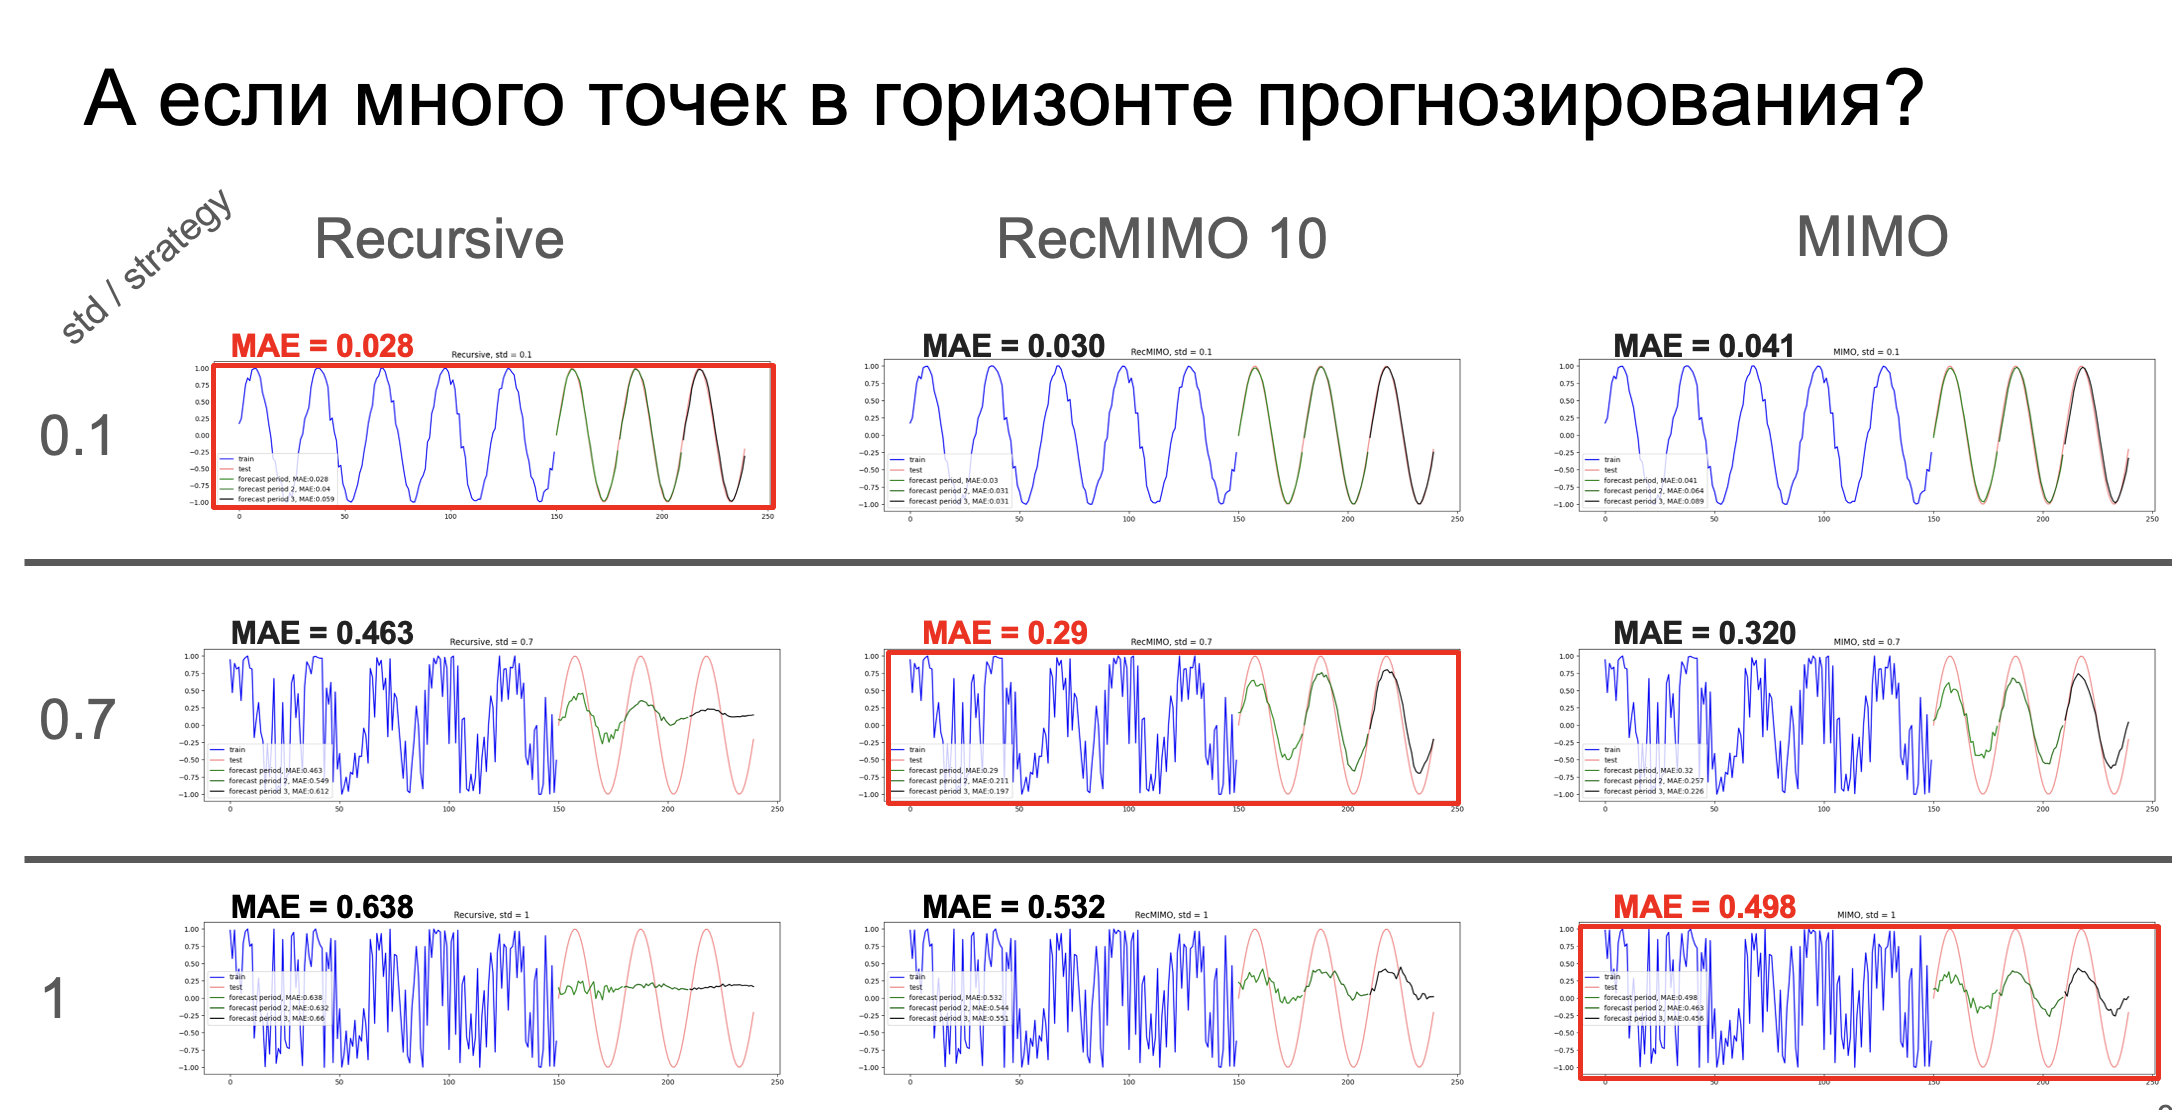

https://github.com/sb-ai-lab/tsururu

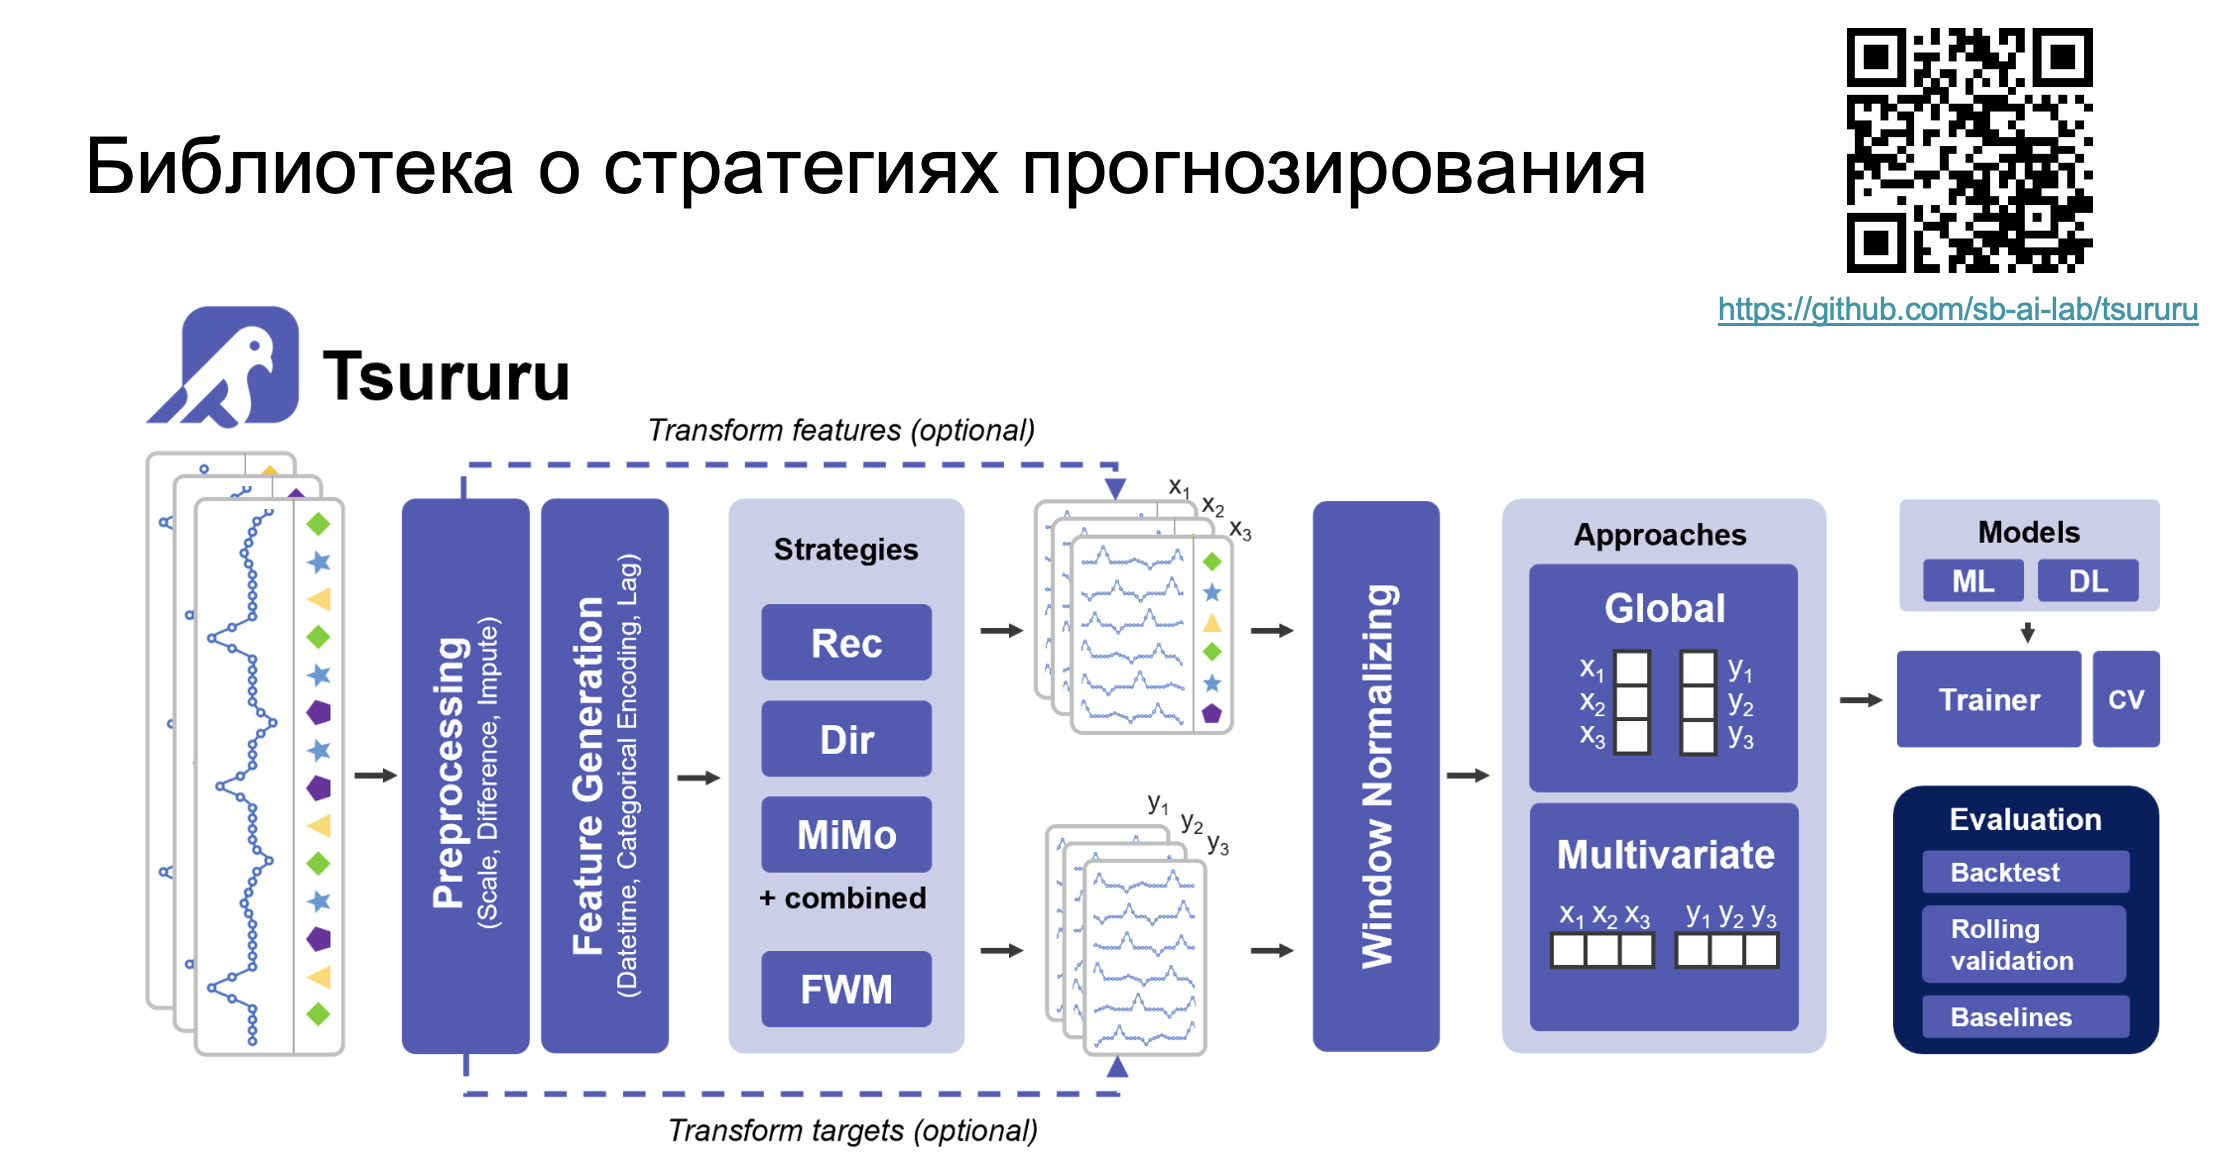